<a href="https://colab.research.google.com/github/totti0223/deep_learning_for_biologists_with_keras/blob/master/notebooks/yeast_GFP_localization_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yeast GFP protein localization classification with CNN

![yeast_image](https://github.com/totti0223/deep_learning_for_biologists_with_keras/raw/master/assets/yeast.jpg)
Above image adopted from http://kodu.ut.ee/~leopoldp/2016_DeepYeast/

##Reference
*Accurate Classification of Protein Subcellular Localization from High-Throughput Microscopy Images Using Deep Learning
Tanel Pärnamaa and Leopold Parts
G3: GENES, GENOMES, GENETICS May 1, 2017 vol. 7 no. 5 1385-1392; https://doi.org/10.1534/g3.116.033654*

http://kodu.ut.ee/~leopoldp/2016_DeepYeast/

# Library import

In [0]:
import csv
import numpy as np
import os
import math

import itertools
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from skimage.exposure import equalize_adapthist

from skimage.io import imread
from skimage.transform import resize

#update imagegenerator function
!pip uninstall keras-preprocessing -y
!pip install git+https://github.com/keras-team/keras-preprocessing.git
from keras_preprocessing.image import ImageDataGenerator as _ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator

import keras
import keras.backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file

from keras import layers,models
from keras.models import Sequential


Uninstalling Keras-Preprocessing-1.0.5:
  Successfully uninstalled Keras-Preprocessing-1.0.5
  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-7_0c8ho_
  Running setup.py bdist_wheel for Keras-Preprocessing ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-tj02yd6z/wheels/03/a0/39/171f6040d36f36c71168dc69afa81334351b20955dc36ce932
Successfully built Keras-Preprocessing


Using TensorFlow backend.


#Data preparation

## Download yeast GFP datasets

In [0]:
def download_data():
    print("Downloading dataset")
    paths = ["main.tar.gz","HOwt_train.txt","HOwt_val.txt","HOwt_test.txt"]
    data_path = get_file(paths[0],origin="http://kodu.ut.ee/~leopoldp/2016_DeepYeast/data/main.tar.gz",extract=True,cache_subdir='deepyeast')
    train_path = get_file(paths[1],origin="http://kodu.ut.ee/~leopoldp/2016_DeepYeast/code/reports/HOwt_train.txt",cache_subdir='deepyeast')
    val_path = get_file(paths[2],origin="http://kodu.ut.ee/~leopoldp/2016_DeepYeast/code/reports/HOwt_val.txt",cache_subdir='deepyeast')
    test_path = get_file(paths[3],origin="http://kodu.ut.ee/~leopoldp/2016_DeepYeast/code/reports/HOwt_test.txt",cache_subdir='deepyeast')
    return data_path,train_path,val_path,test_path

def download_transfer_data():
    print("Downloading dataset for transfer learning")
    paths = ["transfer.tar.gz","HOwt_transfer_train.txt","HOwt_transfer_val.txt","HOwt_transfer_test.txt"]

    data_path = get_file(paths[0], origin='http://kodu.ut.ee/~leopoldp/2016_DeepYeast/data/transfer.tar.gz',extract=True,cache_subdir='deepyeast_transfer')   
    train_path = get_file(paths[1], origin='http://kodu.ut.ee/~leopoldp/2016_DeepYeast/code/image_prep/data/HOwt_transfer_train.txt', cache_subdir='deepyeast_transfer')
    val_path = get_file(paths[2], origin='http://kodu.ut.ee/~leopoldp/2016_DeepYeast/code/image_prep/data/HOwt_transfer_val.txt', cache_subdir='deepyeast_transfer')
    test_path = get_file(paths[3], origin='http://kodu.ut.ee/~leopoldp/2016_DeepYeast/code/image_prep/data/HOwt_transfer_test.txt', cache_subdir='deepyeast_transfer')

data_path, train_path, val_path, test_path = download_data()

print(data_path)
print(train_path)
print(val_path)
print(test_path)

434176/432256 [==============================] - 2s 4us/step
/root/.keras/deepyeast/main.tar.gz
/root/.keras/deepyeast/HOwt_train.txt
/root/.keras/deepyeast/HOwt_val.txt
/root/.keras/deepyeast/HOwt_test.txt


## Read the CSV as pandas dataframe

In [0]:
parent_directory = "/root/.keras/deepyeast/"

train_df = pd.read_csv(train_path,delimiter=" ",names=("filename","class"),dtype={"filename":"str","class":"int"})
train_df["filename"] = parent_directory + train_df["filename"]

valid_df = pd.read_csv(val_path,delimiter=" ",names=("filename","class"),dtype={"filename":"str","class":"int"})
valid_df["filename"] = parent_directory + valid_df["filename"]

test_df = pd.read_csv(test_path,delimiter=" ",names=("filename","class"),dtype={"filename":"str","class":"int"})
test_df["filename"] = parent_directory + test_df["filename"]


train_df[:5]

,filename,class
0,/root/.keras/deepyeast/plate10/015005000-6-151...,0
1,/root/.keras/deepyeast/plate01/007013000-2-626...,6
2,/root/.keras/deepyeast/plate01/003018000-2-262...,1
3,/root/.keras/deepyeast/plate10/004020000-0-141...,3
4,/root/.keras/deepyeast/plate08/006018000-0-113...,1


## Create ImageDataGenerator Class

In [0]:
train_datagen = _ImageDataGenerator(rescale=1/255.)
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                  directory=None,
                                  x_col="filename",
                                  y_col="class",
                                  has_ext = True,
                                  target_size=(64,64),
                                  class_mode="categorical")


valid_datagen = _ImageDataGenerator(rescale=1/255.)
valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_df,
                                  directory=None,
                                  x_col="filename",
                                  y_col="class",
                                  has_ext = True,
                                  target_size=(64,64),
                                  class_mode="categorical")

test_datagen = _ImageDataGenerator(rescale=1/255.)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                  directory=None,
                                  x_col="filename",
                                  y_col="class",
                                  has_ext = True,
                                  target_size=(64,64),
                                  class_mode="categorical")

Found 65000 images belonging to 12 classes.
Found 12500 images belonging to 12 classes.
Found 12500 images belonging to 12 classes.


# Model preparation

## Create the CNN model

In [0]:
#basically follows the CNN network of the cited literature.

model = Sequential([
    #feature extraction layer
    
    #block1
    layers.Conv2D(64,(3,3),padding="same",name="block1_conv1",input_shape=(64,64,3)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(64,(3,3),padding="same",name="block1_conv2"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2),strides=(2,2),name="block1_pool"),
    #block2
    layers.Conv2D(128,(3,3),padding="same",name="block2_conv1"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(128,(3,3),padding="same",name="block2_conv2"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2),strides=(2,2),name="block2_pool"),
    #block3
    layers.Conv2D(256,(3,3),padding="same",name="block3_conv1"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(256,(3,3),padding="same",name="block3_conv2"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(256,(3,3),padding="same",name="block3_conv3"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(256,(3,3),padding="same",name="block3_conv4"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2,2),strides=(2,2),name="block3_pool"),

    layers.Flatten(),
    
    #inference layer
    layers.Dense(512,name="fc1"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),
    
    layers.Dense(512,name="fc2"),
    layers.BatchNormalization(),
    layers.Activation("relu"),    
    layers.Dropout(0.5),
    
    layers.Dense(12,name="prepredictions"),
    layers.Activation("softmax",name="predictions")
    
])

model.compile(optimizer = "adam", loss="categorical_crossentropy", metrics=["accuracy"])


##check the model architecture by model.summary

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
__________

# Training

In [0]:
#limiting the epochs to two. if you have time, change it to larger number and see how well it improves
model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_generator.n//train_generator.batch_size+1,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n//valid_generator.batch_size+1,
                    epochs=50)

Epoch 1/50
  77/2032 [>.............................] - ETA: 6:35 - loss: 2.2565 - acc: 0.2687

KeyboardInterrupt: ignored

## Load the pretrained model weights

In [0]:
#Lets download the pretrained model for people who cannot wait for the model to be sufficiently trained
!wget https://raw.githubusercontent.com/totti0223/deep_learning_for_biologists_with_keras/master/notebooks/1_yeast_best_model.hdf5 -O 1_yeast_best_model.hdf5
    
#Load weights into the model
model.load_weights("1_yeast_best_model.hdf5")

--2019-01-12 10:44:01--  https://raw.githubusercontent.com/totti0223/deep_learning_for_biologists_with_keras/master/notebooks/1_yeast_best_model.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88055192 (84M) [application/octet-stream]
Saving to: ‘1_yeast_best_model.hdf5’

1_yeast_best_model. 100%[===================>]  83.98M   208MB/s    in 0.4s    

2019-01-12 10:44:03 (208 MB/s) - ‘1_yeast_best_model.hdf5’ saved [88055192/88055192]



#Evaluation

## Keras model evaluation function

In [0]:
#lets see what kind of metrics can be obtained
print(model.metrics_names) 

#evaluate train dataset, validation dataset, and test dataset

print("train dataset: ", end = "")
print(model.evaluate_generator(train_generator, steps = train_generator.n//train_generator.batch_size))

print("validation dataset: ", end = "")
print(model.evaluate_generator(valid_generator, steps = valid_generator.n//valid_generator.batch_size))

print("test dataset: ", end = "")
print(model.evaluate_generator(test_generator, steps = test_generator.n//test_generator.batch_size))

['loss', 'acc']
train dataset: [0.10457633427176714, 0.9645209949513607]
validation dataset: [0.41707471961542164, 0.8737568174526789]
test dataset: [0.4666416135162879, 0.8635416666666667]


from the above evaluation, we can confirm that the classifier has 86.3% accuracy with 0.47 loss in the test dataset.
more accuracy can be observed by modifying the CNN, training optimizer, and/or performing dataaugmentation in training dataset. try yourself!

## Sklearn evaluation functions

### Data preparation needed for evaluation

In [0]:
#evaluate the test dataset by sklearn evaluation functions.

#1.first redefine the test generator without shuffling
#2.also modified the batch_size to 10 from 32(default) so that all of the data will be feed.
#note that the above cells evaluation does not feed all the images because the number of images
#cannot be evenly divided by 32, and values slightly changes every time. in order to prevent, define the batch size yourself.
test_datagen = _ImageDataGenerator(rescale=1/255.)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                  directory=None,
                                  x_col="filename",
                                  y_col="class",
                                  has_ext = True,
                                  target_size=(64,64),
                                  class_mode="categorical",shuffle=False,batch_size=10)

Found 12500 images belonging to 12 classes.


In [0]:
#the label of each images in array
true_y = test_generator.classes
print(true_y)

#predicted label of dataset
pred_in_one_hot = model.predict_generator(test_generator, test_generator.n//test_generator.batch_size)

#one hot to numbers
pred_y = np.argmax(pred_in_one_hot,axis=1) 

#Names that correspond to labels
label_names = ['Cell_periphery','Cytoplasm','Endosome','ER','Golgi','Mitochondrion','Nuclear_Periphery','Nucleolus','Nucleus','Peroxisome','Spindle_pole','Vacuole']


[6 7 1 ... 5 2 8]


### Classification report

In [0]:
print(classification_report(true_y,pred_y,target_names=label_names))

                   precision    recall  f1-score   support

   Cell_periphery       0.97      0.87      0.92      1569
        Cytoplasm       0.84      0.92      0.88      1276
         Endosome       0.62      0.83      0.71       689
               ER       0.89      0.92      0.91      1755
            Golgi       0.92      0.82      0.87       382
    Mitochondrion       0.89      0.90      0.90      1243
Nuclear_Periphery       0.94      0.89      0.92      1164
        Nucleolus       0.85      0.92      0.89      1263
          Nucleus       0.95      0.82      0.88      1627
       Peroxisome       0.53      0.81      0.64       164
     Spindle_pole       0.81      0.57      0.67       781
          Vacuole       0.74      0.88      0.80       587

        micro avg       0.86      0.86      0.86     12500
        macro avg       0.83      0.85      0.83     12500
     weighted avg       0.87      0.86      0.86     12500



### Confusion matrix

In [0]:
cnf = confusion_matrix(true_y, pred_y)
print(cnf)


[[1359   67   11   89    2   21    2    1    2    1    0   14]
 [   6 1179   12   40    0   17    5    2    2    2    5    6]
 [   0   36  575   10    5   11    3    0    0    6   12   31]
 [  28   37   19 1616   12    9   10    0    1    2    1   20]
 [   0    1    6   15  314    7    0    7    0    1    3   28]
 [   2    4   26   11    1 1118    7    5   13   34    6   16]
 [   0    5   10   10    1   10 1037    5   17   12   22   35]
 [   0    7   15    1    0    5    8 1167   26    1   26    7]
 [   1   22   10   13    0   23   10  173 1332    8   11   24]
 [   0    0    5    1    1    0    2    1    0  133   21    0]
 [   0   40  214    3    0   15    8    0    3   49  448    1]
 [   0    1   27    2    5   14    8   11    2    1    0  516]]


lets modify the above data for easy visualization

In [0]:
#confusion matrix drawing function provided by sklearn
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
Normalized confusion matrix


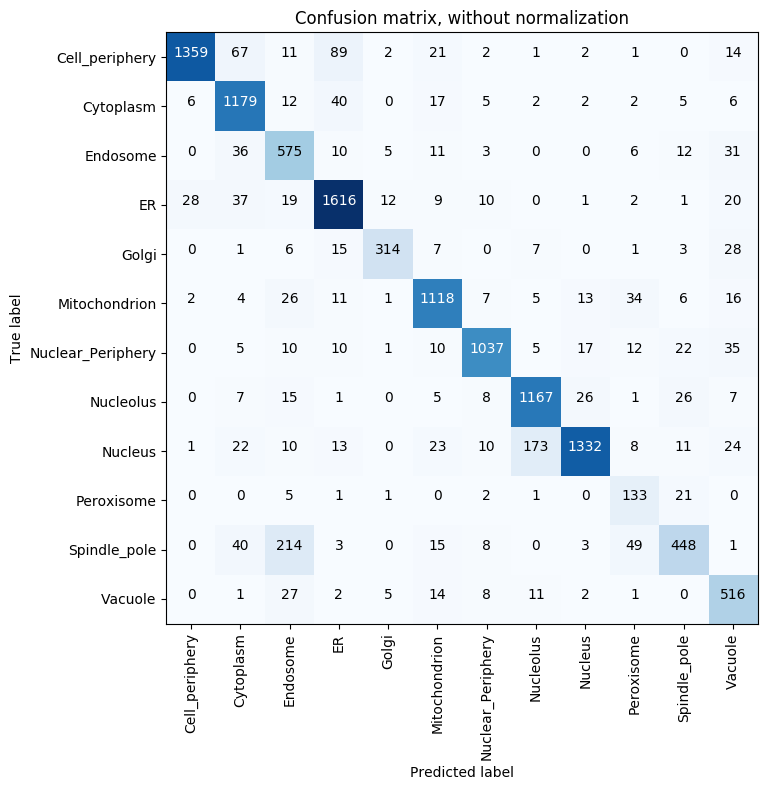

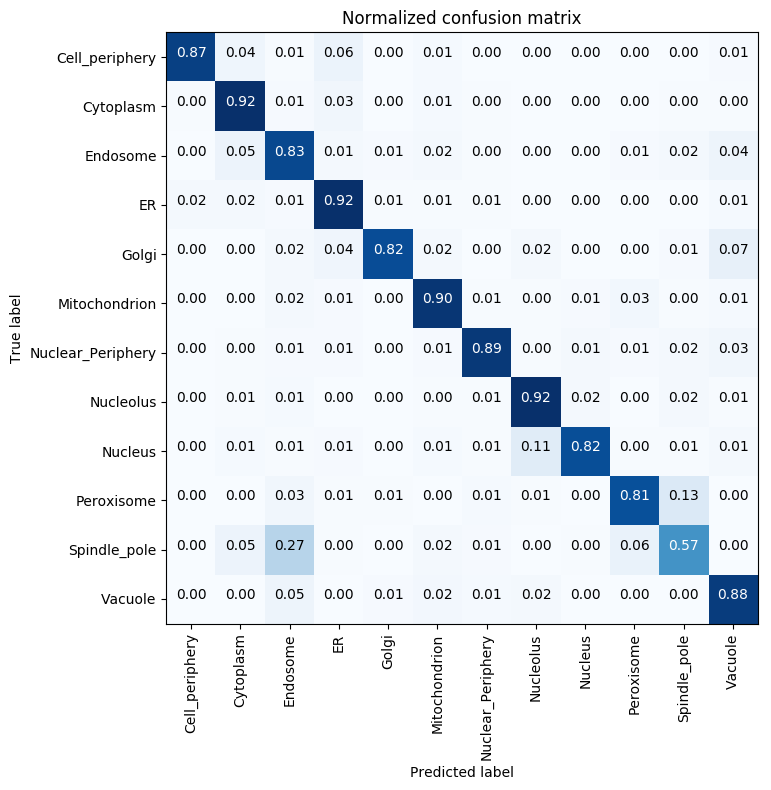

In [0]:
plt.style.use('default')

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, classes=label_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, classes=label_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
